In [1]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
from scipy.interpolate import interp1d
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [2]:
fs, p = wavfile.read('sonido-presion/presion_segmento_2.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_2.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_2.wav')
fs, s_s = wavfile.read('sonido-presion/simulacion_segmento_2.wav')


In [3]:
#normalizo
p = p.astype(np.float32)
s_m = s_m / max(s_m)
s_s = s_s[:-1] / max(s_s)
b = b[:-1]

In [4]:

dt = 1/fs
N  = len(p)
t = np.arange(0, N) * dt

print(f'frec muestreo: {fs} \n dt muestreo: {dt} \n tiempo total de medición {t[-1]} s')

frec muestreo: 44150 
 dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.9829898074745187 s


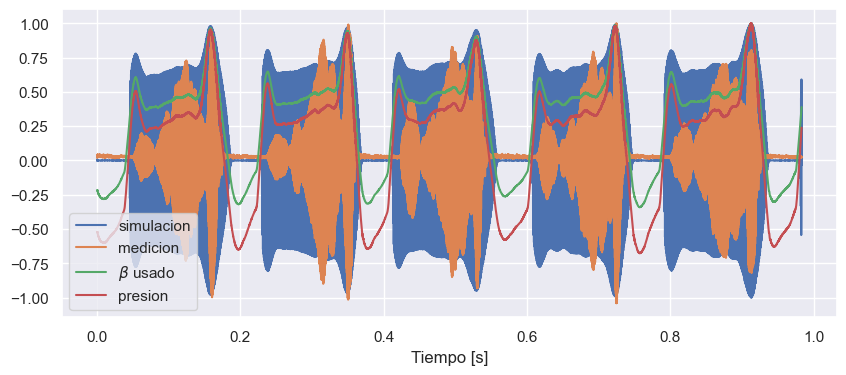

In [5]:
plt.figure(figsize=(10,4))

plt.plot(t,s_s, label = 'simulacion')
plt.plot(t,s_m, label = 'medicion')
plt.plot(t,b/max(b), label = r'$\beta$ usado')
plt.plot(t,p/max(p), label = r'presion')
plt.xlabel('Tiempo [s]')
plt.legend()

#### Calculo Sigmas del sonido y la simulación

In [6]:
#sigma del sonido
sigma_s = np.std(s_s[b<0])

print(f'Desviación estandar de la señal de sonido: {sigma_s} ')

sigma_m = np.std(s_m[b<0])

print(f'Desviación estandar de la señal de la simulacion: {sigma_m} ')




Desviación estandar de la señal de sonido: 0.023583216592669487 
Desviación estandar de la señal de la simulacion: 0.0050521525399703756 


#### Separo los "pulsos"

11
[1775, 8072, 9907, 16136, 17989, 24451, 26613, 32817, 34719, 41187, 43130]
[1775, 8072, 9907, 16136, 17989, 24451, 26613, 32817, 34719, 41187, 43130]


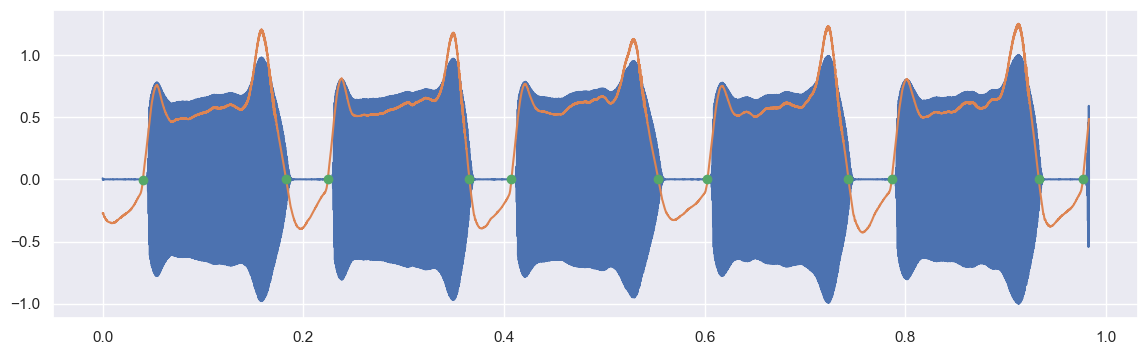

In [8]:
index_split = []
for i in range(len(t)-1):
    if b[i]*b[i+1] < 0:
        #print(f'Cambio de signo en t= {t[i]}')
        index_split.append(i)
print(len(index_split))
print(index_split)

print(index_split)

plt.figure(figsize=(14,4))
plt.plot(t,s_s)
plt.plot(t,b)
plt.plot(t[index_split], b[index_split], 'o')

In [9]:
#ordeno los datos

pulsos = {i: {'t' : t[index_split[i]:index_split[i+1]],
              's_s': s_s[index_split[i]:index_split[i+1]],
              's_m': s_m[index_split[i]:index_split[i+1]],
              'b': b[index_split[i]:index_split[i+1]]} for i in range(10) if i%2==0 } 
print(len(pulsos))

5


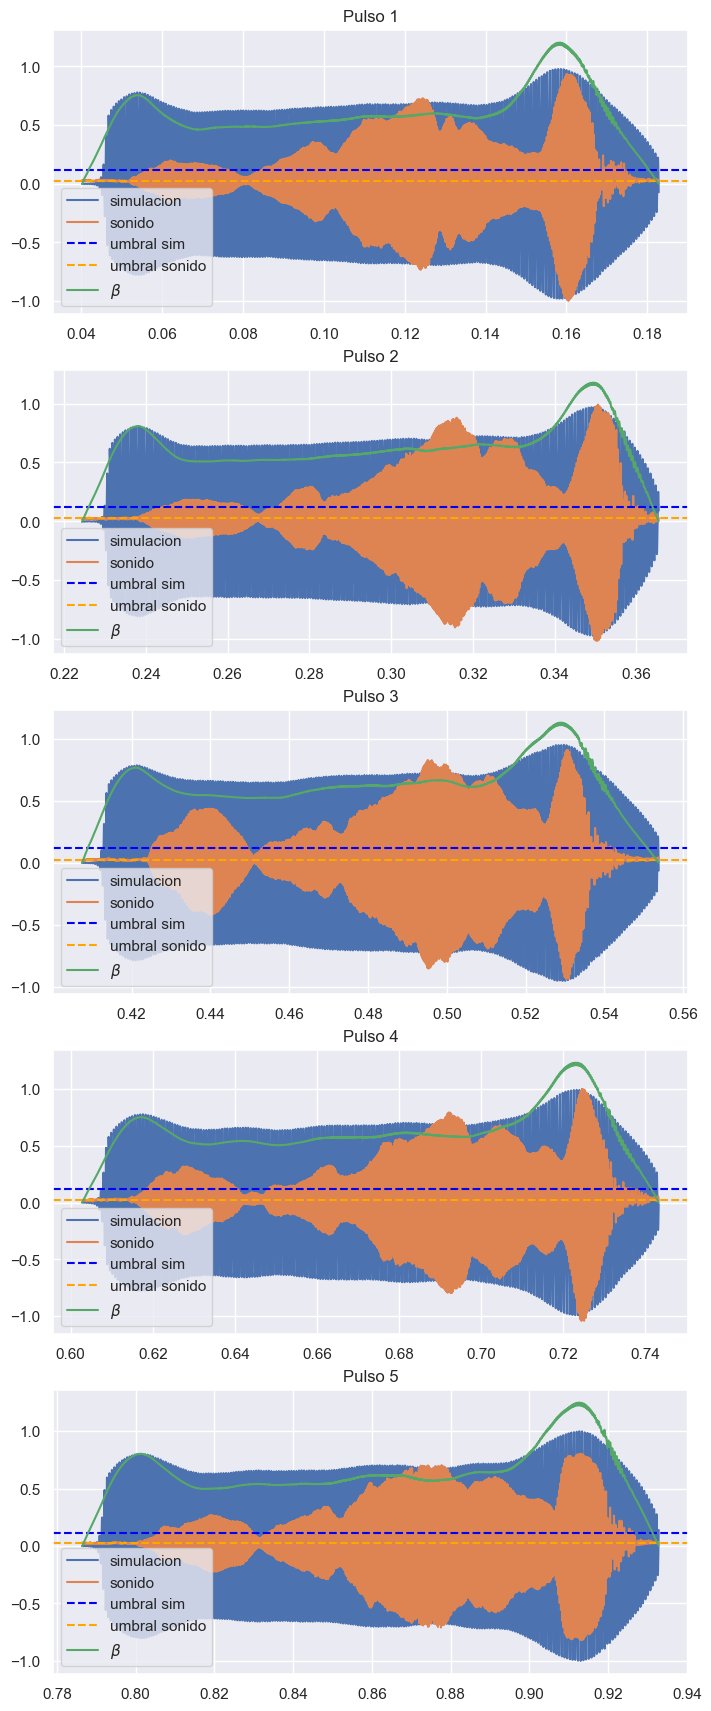

In [12]:
fig, axes = plt.subplots(5, 1, figsize=(7,17), constrained_layout=True, sharey=False)
axs = axes.flatten()

for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    s_s_ = pulsos[ps]['s_s']
    s_m_ = pulsos[ps]['s_m']
    b_ = pulsos[ps]['b']
    umbral_s = sigma_s * 5
    umbral_m = sigma_m * 5
    axs[i].plot(t_,s_s_, label = 'simulacion')
    axs[i].plot(t_,s_m_, label = 'sonido')
    axs[i].axhline( umbral_s, label = 'umbral sim', color = 'blue', ls = '--')
    axs[i].axhline( umbral_m, label = 'umbral sonido', color = 'orange', ls = '--')
    axs[i].plot(t_,b_, label = r'$\beta$')
    axs[i].set_title(f'Pulso {i+1}')
    axs[i].legend()
    


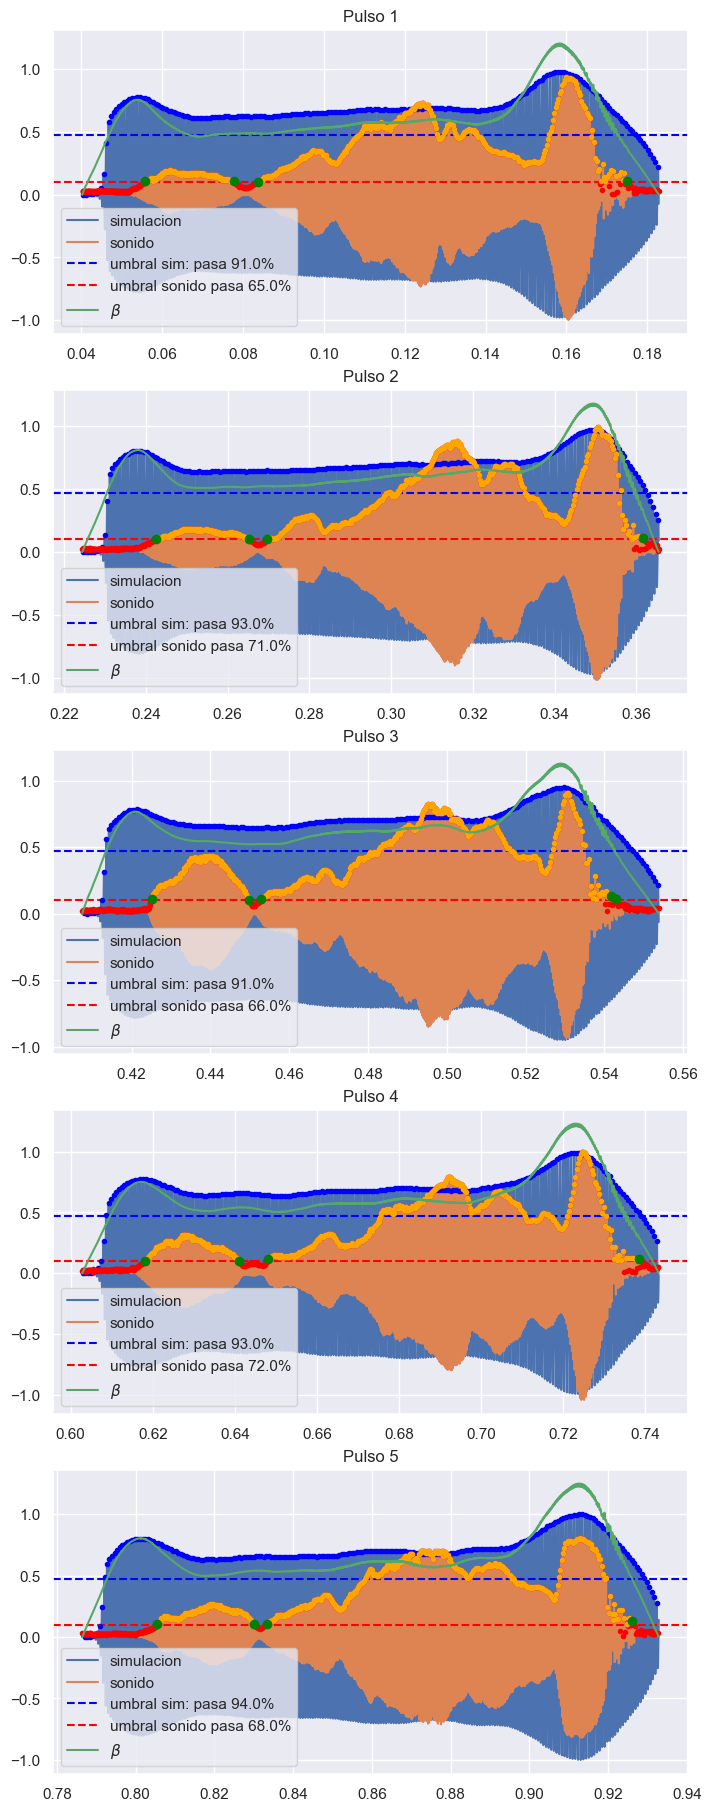

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(7,18), constrained_layout=True, sharex=False)
axs = axes.flatten()

for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    s_s_ = pulsos[ps]['s_s']
    s_m_ = pulsos[ps]['s_m']
    b_ = pulsos[ps]['b']
    picos_s, _ = signal.find_peaks(s_s_, height = 0 )  
    picos_m, _ = signal.find_peaks(s_m_, height = 0 )  

    umbral_s = sigma_s * 20
    umbral_m = sigma_m * 20

    #indices de los picos que pasan el umbral
    index_fon_s = [ps for ps in picos_s if s_s_[ps] > umbral_s]
    index_fon_m = [pm for pm in picos_m if s_m_[pm] > umbral_m]

    #fraccion de los picos que pasan el umbral
    fon_s = len(index_fon_s)/ len(picos_s)
    fon_m = len(index_fon_m)/ len(picos_m)

    #indices de los intervalos de fonacion (criterio: que no sean consecutivos)
    index_intervalo_fon_m = [index_fon_m[0]]
    tresh = max(np.diff(picos_m)) * 2 # criterio para determnar si los picos son consecutivos o no
    for j in range(len(index_fon_m)):
        if index_fon_m[j] - index_fon_m[j-1] > tresh:
            index_intervalo_fon_m.append(index_fon_m[j])
        if j < len(index_fon_m)-1:
            if index_fon_m[j+1] - index_fon_m[j] > tresh:
                index_intervalo_fon_m.append(index_fon_m[j])
    index_intervalo_fon_m.append(index_fon_m[-1])
    

    #print(f'Porcentaje de fonación para el pulso {i+1}:')
    #print(f'Simulación: {fon_s * 100}%')
    #print(f'Medición: {fon_m * 100}%')
    axs[i].plot(t_,s_s_, label = 'simulacion')
    axs[i].plot(t_,s_m_, label = 'sonido')
    axs[i].axhline( umbral_s,label = f'umbral sim: pasa {np.round(fon_s*100)}%', color = 'blue', ls = '--')
    axs[i].axhline( umbral_m,label = f'umbral sonido pasa {np.round(fon_m*100)}%', color = 'red', ls = '--')

    #axs[i].plot(t_, umbral_s, label = f'umbral sim: pasa {np.round(fon_s*100)}%', color = 'blue', ls = '--')
    #axs[i].plot(t_, umbral_m, label = f'umbral sonido pasa {np.round(fon_m*100)}%', color = 'orange', ls = '--')
    axs[i].plot(t_[picos_s], s_s_[picos_s], '.', color = 'blue')
    axs[i].plot(t_[picos_m], s_m_[picos_m], '.', color = 'red')
    axs[i].plot(t_[index_fon_m], s_m_[index_fon_m], '.', color = 'orange')
    axs[i].plot(t_[index_intervalo_fon_m] , s_m_[index_intervalo_fon_m] , 'o', color = 'green')
    axs[i].plot(t_,b_, label = r'$\beta$')
    axs[i].set_title(f'Pulso {i+1}')
    axs[i].legend()